In [2]:
import pyspark
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.functions import lit
from pyspark.sql.functions import udf
from math import *
from pyspark.sql.types import *
#!pip install geopy
import geopy
from geopy.geocoders import Nominatim
from geopy.distance import great_circle
geolocator = Nominatim()
#!pip install seaborn
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
import random 

In [3]:
# country "Bonaire, Sint Eustatius, and Saba" is causing issues with split , removed it for now 
data  = sc.textFile("/resources/data/20152-summary.csv").map(lambda row : row.split(","))

# remove first row 
data_filtered = data.filter(lambda row : row[0]!="DEST_COUNTRY_NAME")

flights_rdd = data_filtered.map(lambda x: Row(DEST_COUNTRY_NAME=x[0], ORIGIN_COUNTRY_NAME=x[1],count = int(x[2])))

flights_df = flights_rdd.toDF()


In [4]:
flights_rdd = data_filtered.map(lambda x: Row(DEST_COUNTRY_NAME=x[0], ORIGIN_COUNTRY_NAME=x[1],count = int(x[2])))

In [5]:
flights_rdd.take(2)

[Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Romania', count=15),
 Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Croatia', count=1)]

In [6]:
flights_df = flights_rdd.toDF()

In [7]:
flights_df.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: long (nullable = true)



In [8]:
flights_df.describe().show()

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|              254|
|   mean|1784.248031496063|
| stddev|23217.24308457226|
|    min|                1|
|    max|           370002|
+-------+-----------------+



In [9]:
# busiest routes 
top_flights = flights_df.sort('count',ascending=False)

top_flights.show(10)

+-----------------+-------------------+------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|
+-----------------+-------------------+------+
|    United States|      United States|370002|
|    United States|             Canada|  8483|
|           Canada|      United States|  8399|
|    United States|             Mexico|  7187|
|           Mexico|      United States|  7140|
|   United Kingdom|      United States|  2025|
|    United States|     United Kingdom|  1970|
|            Japan|      United States|  1548|
|    United States|              Japan|  1496|
|          Germany|      United States|  1468|
+-----------------+-------------------+------+
only showing top 10 rows



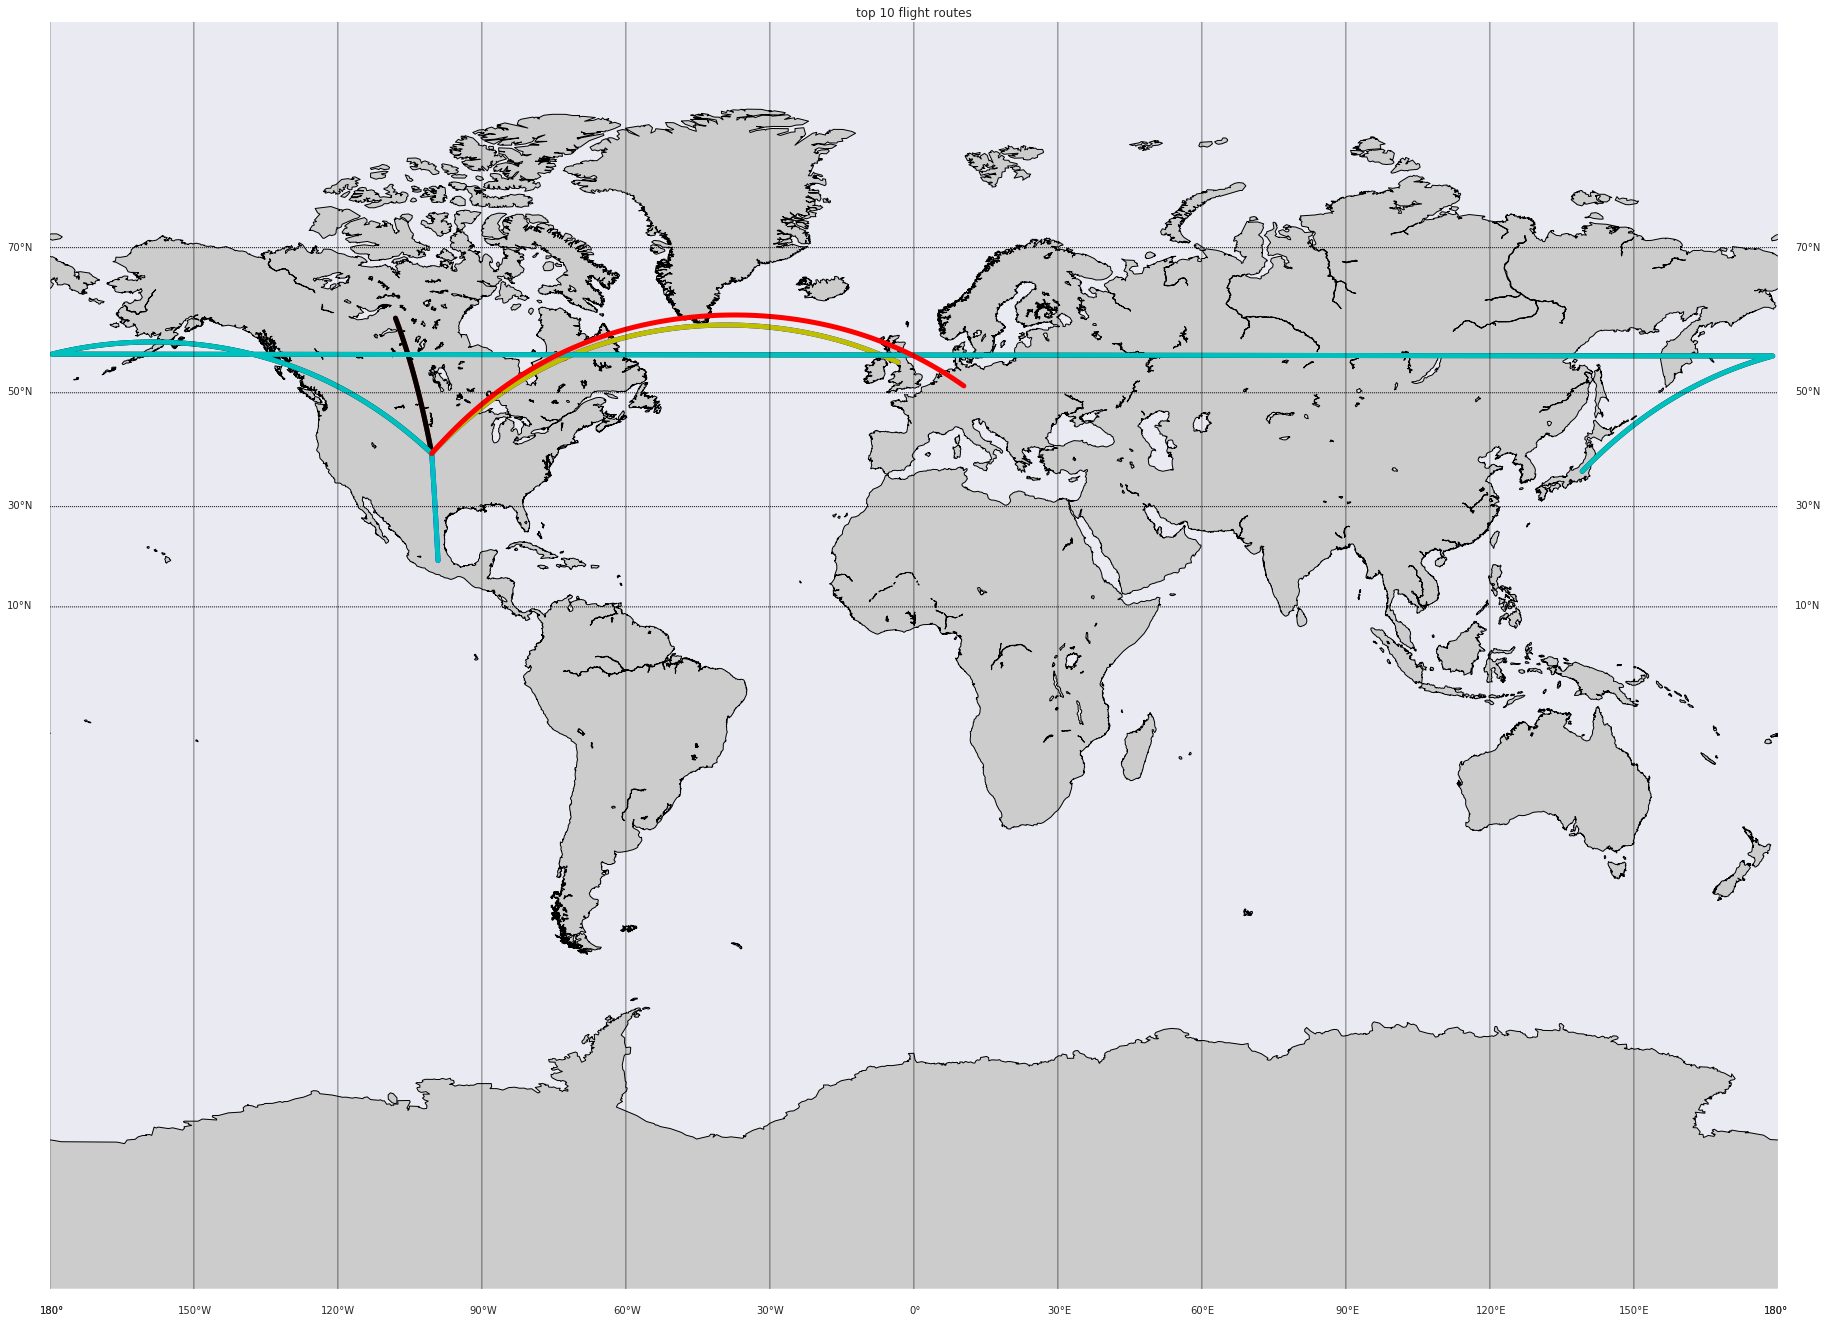

In [10]:
# lets see the top 10 routes by traffic on  a map 
# intersections can help identify some hubs 
%matplotlib inline
flights_plot = top_flights.limit(10).toPandas()
# create new figure, axes instances.
fig=plt.figure(figsize=(30,30))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(projection='mill',resolution='l')
colors = ['r','b','g','m','y','c','k']
i=0
for flight in flights_plot.iterrows():
    i+=1
    location1 = geolocator.geocode(flight[1][0])
    location2 = geolocator.geocode(flight[1][1])
    m.drawgreatcircle(location1.longitude,location1.latitude,location2.longitude,location2.latitude,linewidth=5,color=random.choice(colors))
    
m.drawcoastlines()
m.fillcontinents()
# draw parallels
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
ax.set_title('top 10 flight routes')

plt.show()

In [11]:
# hottest destinations 

top_destinations = flights_df.groupBy('DEST_COUNTRY_NAME').agg({'count': 'sum'})
top_destinations.sort('sum(count)',ascending=False).show(10)


+------------------+----------+
| DEST_COUNTRY_NAME|sum(count)|
+------------------+----------+
|     United States|    411293|
|            Canada|      8399|
|            Mexico|      7140|
|    United Kingdom|      2025|
|             Japan|      1548|
|           Germany|      1468|
|Dominican Republic|      1353|
|       South Korea|      1048|
|       The Bahamas|       955|
|            France|       935|
+------------------+----------+
only showing top 10 rows



In [12]:
top_destinations.printSchema()
#dest_plot.describe()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- sum(count): long (nullable = true)



In [25]:
## lets now see these destinations on the map (countries not)
##take log scale to deal with skewness in data 
dest_plot = top_destinations.sort('sum(count)',ascending=False).limit(30).toPandas()
dest_plot['sum(count)'] = np.log10(dest_plot['sum(count)'])
#!pip install plotly
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pandas as pd
init_notebook_mode(connected=True) 

data = [ dict(
        type = 'choropleth',
        locationmode = "country names",
        locations =dest_plot ['DEST_COUNTRY_NAME'],
        z = dest_plot['sum(count)'],
        text = dest_plot ['DEST_COUNTRY_NAME'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        range = [0,500000],
        reversescale = True,
        zrangemode="tozero",
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'log(number of flights)'),
      ) ]

layout = dict(
    title = 'Hottest Destinations',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'miller'
        )
    )
)

fig = dict( data=data, layout=layout )
iplot( fig, validate=False, filename='d3-world-map')


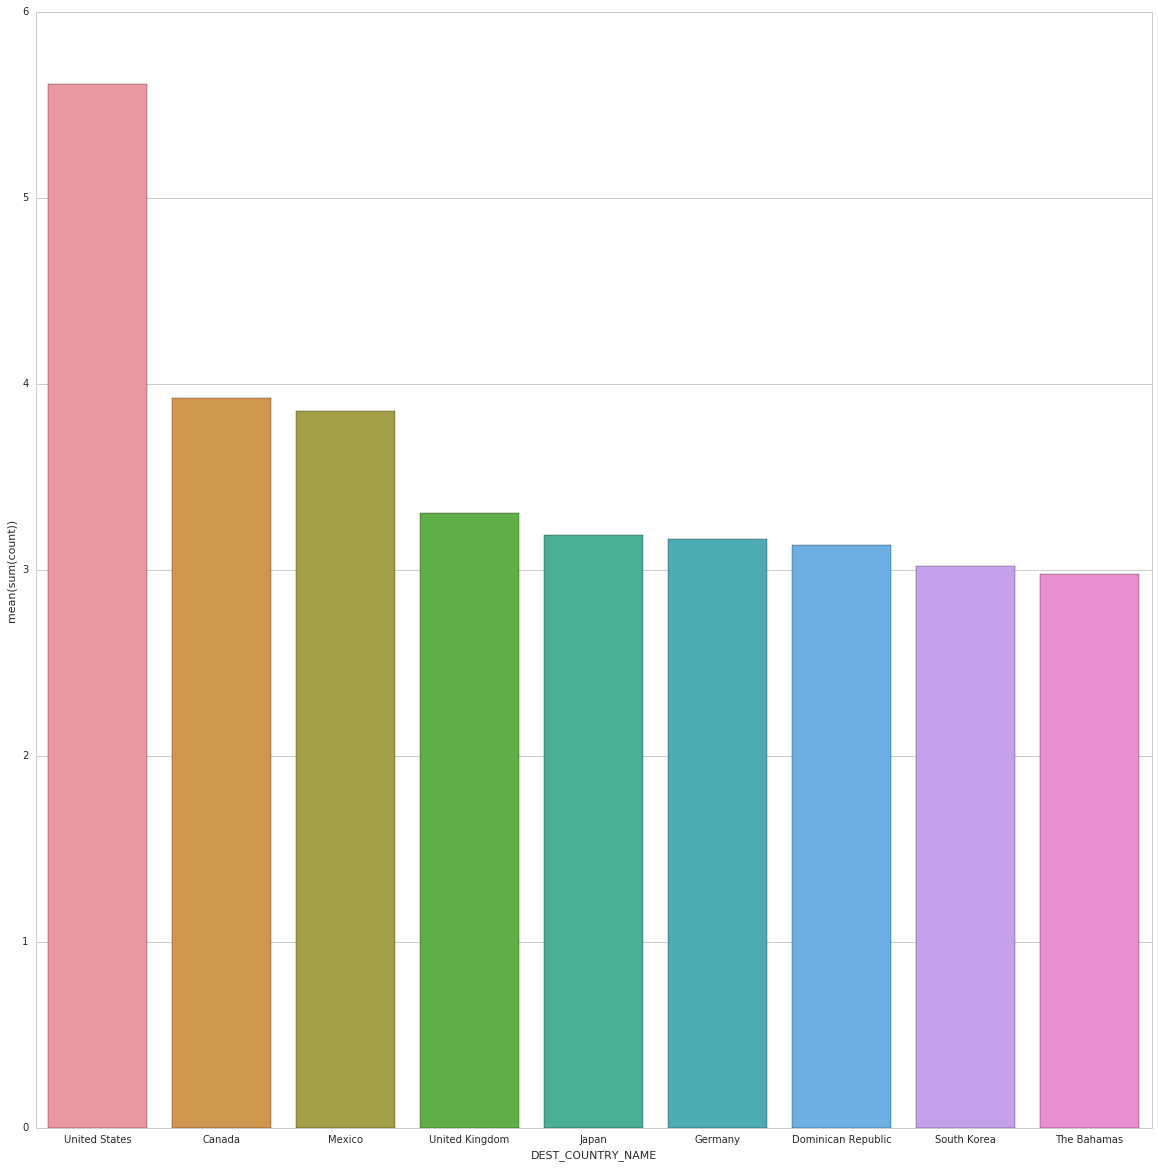

In [26]:
import seaborn as sns
fig, ax = plt.subplots()
sns.set_style("whitegrid")
sns.barplot(ax=ax,x='DEST_COUNTRY_NAME', y='sum(count)', data=dest_plot.iloc[0:9])
fig.set_size_inches(20,20)


In [16]:
#busiest sources 

top_sources = flights_df.groupBy('ORIGIN_COUNTRY_NAME').agg({'count': 'sum'})
top_sources.sort('sum(count)',ascending=False).show(10)


+-------------------+----------+
|ORIGIN_COUNTRY_NAME|sum(count)|
+-------------------+----------+
|      United States|    411908|
|             Canada|      8483|
|             Mexico|      7187|
|     United Kingdom|      1970|
|              Japan|      1496|
| Dominican Republic|      1420|
|            Germany|      1336|
|        The Bahamas|       986|
|             France|       952|
|              China|       920|
+-------------------+----------+
only showing top 10 rows



In [17]:
# lets see which countries visit Egypt the most 

egypt_flights = flights_df.filter(flights_df.DEST_COUNTRY_NAME=='Egypt')

In [18]:
egypt_flights.take(5)

[Row(DEST_COUNTRY_NAME=u'Egypt', ORIGIN_COUNTRY_NAME=u'United States', count=15)]

In [ ]:
#only 1 route to and from Egypt

In [19]:
# lets see if we can calculate the distance between each 2 countries to get some insights 


def GetDistance(country1,country2):
    location1 = geolocator.geocode(country1)
    location2 = geolocator.geocode(country2)
    loc1=(location1.latitude,location1.longitude)
    loc2=(location2.latitude,location2.longitude)
    return(great_circle(loc1, loc2).miles)

DistCalculator = udf(GetDistance,FloatType())
    




In [20]:

flights_df_dist = flights_df.withColumn("Dist",DistCalculator(flights_df.ORIGIN_COUNTRY_NAME,flights_df.DEST_COUNTRY_NAME))

flights_df_dist.show(3)

+-----------------+-------------------+-----+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|     Dist|
+-----------------+-------------------+-----+---------+
|    United States|            Romania|   15|5612.2607|
|    United States|            Croatia|    1|5387.0664|
|    United States|            Ireland|  344| 4191.576|
+-----------------+-------------------+-----+---------+
only showing top 3 rows



In [22]:
# dsiplay longest 10 flights 

top_flights = flights_df_dist.sort('Dist',ascending=False)


In [23]:
# Display shortest 10 flights 

short_flights = flights_df_dist.sort('Dist',ascending= True )

short_flights.show(10)

+-----------------+-------------------+------+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|     Dist|
+-----------------+-------------------+------+---------+
|    United States|      United States|370002|      0.0|
|          Georgia|      United States|     2|1094.2148|
|    United States|            Georgia|     1|1094.2148|
|           Mexico|      United States|  7140|1408.6868|
|    United States|             Mexico|  7187|1408.6868|
|    United States|             Canada|  8483|1505.6578|
|           Canada|      United States|  8399|1505.6578|
|             Cuba|      United States|   466|  1630.39|
|    United States|               Cuba|   478|  1630.39|
|    United States|        The Bahamas|   986|1663.8163|
+-----------------+-------------------+------+---------+
only showing top 10 rows



In [25]:
flights_df.show(2)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
+-----------------+-------------------+-----+
only showing top 2 rows



In [24]:
flights_df_dist.show(10)

+-----------------+-------------------+-----+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|     Dist|
+-----------------+-------------------+-----+---------+
|    United States|            Romania|   15|5612.2607|
|    United States|            Croatia|    1|5387.0664|
|    United States|            Ireland|  344| 4191.576|
|            Egypt|      United States|   15|6845.6377|
|    United States|              India|   62| 8145.609|
|    United States|          Singapore|    1|  9212.66|
|    United States|            Grenada|   62|3034.9038|
|       Costa Rica|      United States|  588|2273.8965|
|          Senegal|      United States|   40| 5374.475|
|          Moldova|      United States|    1|5654.2524|
+-----------------+-------------------+-----+---------+
only showing top 10 rows

